In [2]:
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

In [3]:
# fragment_file = '../input/Beer_3_T10_POS_fragments.csv'
fragment_file = '/Users/simon/Downloads/Beer_3_full1_5_2E5_pos_fragments.csv'
data = pd.DataFrame.from_csv(fragment_file)

In [4]:
data = data.fillna(0)
data_array = np.array(data)
peak_names = list(data.columns.values)

In [5]:
l = np.sqrt((data_array**2).sum(axis=0))
norm_data = np.divide(data_array,l)

In [6]:
import scipy.spatial.distance as distance
import scipy.cluster.hierarchy as hierarchy

<p>Following cell does Scipy hierarchical clustering</p>

In [106]:
clustering = hierarchy.fclusterdata(norm_data.transpose(),0.8,criterion = 'distance',metric='euclidean',method='single')
print "Found {} clusters".format(np.max(clustering))

Found 537 clusters


<p>Greedy cosine clustering</p>

In [37]:
cosine_sim = np.dot(norm_data.transpose(),norm_data)
finished = False
total_intensity = data_array.sum(axis=0)
total_intensity = total_intensity
n_features,n_parents = data_array.shape
clustering = np.zeros((n_parents,),np.int)
current_cluster = 1
thresh = 0.7
while not finished:
#     Find the cluster with the max intensity left
    current = np.argmax(total_intensity)
    total_intensity[current] = 0.0
    count += 1
    clustering[current] = current_cluster
    friends = np.where((cosine_sim[current,:]>thresh) * (total_intensity > 0.0))[0]
    clustering[friends] = current_cluster
    total_intensity[friends] = 0.0
    left = np.where(total_intensity > 0.0)[0]
    if len(left) == 0:
        finished = True
    current_cluster += 1

In [38]:
import networkx as nx
from networkx.algorithms import bipartite

In [84]:
min_size_to_plot = 4
node_no = 0
G = nx.Graph()
uc = np.unique(clustering)
cluster_nodes = {}
singleton_clusters = []
for cluster in uc:
    members = np.where(clustering == cluster)[0]
    if len(members) < min_size_to_plot:
        singleton_clusters.append(cluster)
        continue
    cluster_nodes[cluster] = node_no
    G.add_node(node_no,bipartite=0)
    node_no += 1

peak_nodes = {}
for i,name in enumerate(peak_names):
    this_cluster = clustering[i]
    if this_cluster in cluster_nodes:
        peak_nodes[name] = node_no
        G.add_node(node_no,bipartite=1)
        G.add_edge(node_no,cluster_nodes[clustering[i]])
        node_no += 1



In [85]:
C,P = bipartite.sets(G)
n_clusters = len(C)
n_rows = np.ceil(np.sqrt(n_clusters))
pos = {}
current_row = 0
current_col = 0
cstep = 2.0
for c in C:
    n_list = G.neighbors(c)
    pos[c] = [cstep*current_row,cstep*current_col]
#     find neighbours
    step = 2*np.pi/len(n_list)
    angle = 0.0
    for n in n_list:
        x_pos = 0.75*np.sin(angle)
        y_pos = 0.75*np.cos(angle)
        pos[n] = [pos[c][0]+x_pos,pos[c][1]+y_pos]
        angle += step
    current_col += 1
    if current_col >= n_rows:
        current_col = 0
        current_row += 1
    

In [98]:
def draw_network(G,pos,C,P,interest_nodes,output_name,title):
    nx.draw_networkx_edges(G,pos,width=0.2)
    nx.draw_networkx_nodes(G,pos,nodelist=C,node_size = 1,node_color = 'g',linewidths=0.1)
    nx.draw_networkx_nodes(G,pos,nodelist=P,node_size = 0.5,node_color = 'b',linewidths=0.1)
    nx.draw_networkx_nodes(G,pos,nodelist=interest_nodes,node_size=2,node_color='r',linewidths=0.1)
    plt.title(title)
    plt.axis('off')
    plt.savefig(output_name)

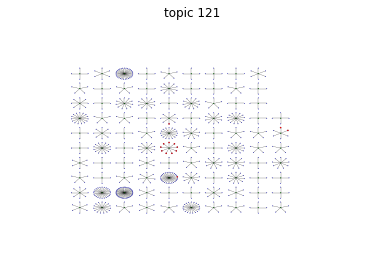

In [99]:
ions_of_interest_121 = ['235.11886_398.577_9934',
'235.11867_414.273_9908',
'235.10771_409.09_9882',
'553.30972_304.981_21426',
'310.21252_240.354_16139',
'277.1474_435.83_13480',
'277.15852_427.098_13504',
'156.07679_752.304_3316',
'251.14993_409.09_11259',
'156.07677_621.074_3303',
'198.08729_481.308_6733',
'110.07129_621.074_324',
'362.21659_503.147_18445',
'198.11249_458.36_6829',
'364.16145_465.819_18641',
'364.1613_428.341_18634',
'195.08761_510.903_6406',
'480.18217_599.71_20955',
'522.2161_463.346_21244',
'522.21623_469.707_21247'
]
interest_nodes = [n for i,n in peak_nodes.items() if i in ions_of_interest_121]
draw_network(G,pos,C,P,interest_nodes,'euclidean_121.pdf','topic 121')

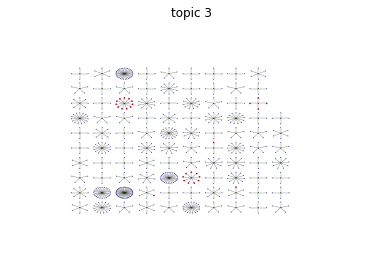

In [100]:
ions_of_interest_3 = ['314.15894_851.554_16340',
'513.18921_208.313_21149',
'666.51234_218.245_21676',
'666.5124_225.864_21683',
'538.28021_240.354_21342',
'232.06382_549.717_9778',
'328.17553_652.517_16968',
'121.06484_448.381_818',
'121.06482_459.598_809',
'121.06478_199.485_784',
'390.21183_469.707_19966',
'246.07926_409.09_10848',
'246.07935_398.577_10863',
'314.15956_409.09_16346',
'152.12813_395.725_3095',
'138.09137_459.598_2061',
'138.04915_482.766_1990',
'138.04296_484.002_1973',
'152.0376_389.139_2963',
'180.13823_1067.42_5365',
'152.10695_198.223_3045',
'152.10698_260.221_3062',
'300.14413_595.985_15468',
'166.1226_692.788_4241',
'121.06478_699.082_792',
'121.06479_260.221_799',
'246.13339_410.326_10880',
'471.23791_207.077_20922',
'318.15479_432.107_16447',
'404.20663_240.354_20189',
'314.13861_269.685_16325',
'166.12265_282.677_4258',
'166.08626_290.373_4191',
'152.07054_491.622_3029',
'166.08628_377.302_4202',
'166.04983_421.989_4119',
'180.10186_355.669_5307']
interest_nodes = [n for i,n in peak_nodes.items() if i in ions_of_interest_3]
draw_network(G,pos,C,P,interest_nodes,'euclidean_3.pdf','topic 3')

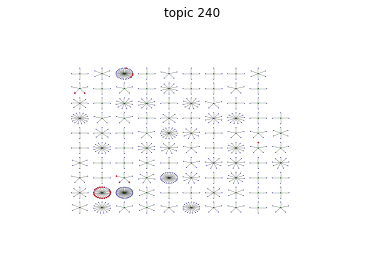

In [101]:
ions_of_interest_240 = ['414.19697_313.227_20264',
'1026.3715_663.894_21884',
'1008.361_689.007_21858',
'991.33379_689.007_21848',
'432.20761_514.793_20469',
'279.15477_366.931_13715',
'279.15486_379.781_13721',
'1009.34458_661.235_21873',
'846.30793_686.519_21828',
'434.18699_648.791_20506',
'486.18187_520.976_20980',
'525.21116_666.373_21250',
'580.20871_656.24_21497',
'684.25548_677.736_21758',
'829.28121_676.494_21818',
'829.28091_685.234_21808',
'342.13953_542.28_17366',
'342.13951_553.527_17356',
'388.18119_514.793_19928',
'522.2028_670.092_21213',
'522.20268_659.996_21182',
'667.22894_676.494_21709',
'667.2285_666.373_21690',
'360.14987_655.001_18389',
'649.21868_677.736_21623',
'342.13944_670.092_17345',
'505.1764_661.235_21097',
'603.15348_657.516_21552',
'270.11823_554.77_12793',
'371.1549_514.793_19276',
'487.16565_661.235_20989',
'198.0972_696.582_6750',
'397.17058_314.478_20080',
'325.11294_514.793_16684',
'270.15453_478.834_12801',
'270.15454_467.234_12831',
'270.09467_465.819_12761',
'242.12327_552.287_10533',
'414.19662_411.615_20250',
'388.14759_489.128_19917',
'180.08662_562.308_5249']
interest_nodes = [n for i,n in peak_nodes.items() if i in ions_of_interest_240]
draw_network(G,pos,C,P,interest_nodes,'euclidean_240.pdf','topic 240')